In [ ]:
# Installér spacy sprogmodel for dansk (hvis ikke installeret i forvejen)

#!python -m spacy download 'da_core_news_sm'

In [8]:
# indlæs pakker

import os
import re
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

import plotnine
plotnine.options.figure_size = (12, 10)

import spacy

nlp = spacy.load('da_core_news_sm')

### Forstillet problemstilling

> Kan vi identificere SPAM uden brug af labels

Tilgang: Teste om spam og ham beskeder har så forskellige sproglige karakteristika at de naturligt danner separate klynger

In [9]:
# indlæs data
df = pd.read_csv('/Users/jeppefl/Library/CloudStorage/OneDrive-AalborgUniversitet/01_work/01_undervisning/02_sds1/03_data/spam.csv', encoding='cp1252')

df = df[['v1', 'v2']].copy()
df.columns = ['label', 'message']
df = df.dropna()

In [10]:
# Brug subset for hurtigere beregning (fjern [:1000] for fuld analyse)
df_analysis = df[:1000].copy()
messages = df_analysis['message'].tolist()

## Klyngeanalyse af tekster: CountVectorizer (rå tællinger af ord)

In [11]:
# Dan vectorizer
vectorizer_count = CountVectorizer(
    min_df=0.05,  # Ord skal forekomme i mindst 5% af dokumenter
    max_df=0.9,   # Ord må max forekomme i 90% af dokumenter
    max_features=500  # Begræns til 500 vigtigste ord
)

# Transform beskeder til numeriske vektorer
transformed_count = vectorizer_count.fit_transform(messages)
count_array = transformed_count.toarray()
count_df = pd.DataFrame(count_array, columns=vectorizer_count.get_feature_names_out())

print(f"Antal features (ord): {count_df.shape[1]}")
print(f"Top 10 mest almindelige ord: {list(count_df.sum().sort_values(ascending=False).head(10).index)}")

Antal features (ord): 37
Top 10 mest almindelige ord: ['you', 'to', 'the', 'and', 'in', 'is', 'my', 'for', 'me', 'your']


```
╔════════════════════════════════════════════════════════════════════╗
║              COUNTVECTORIZER PREPROCESSING OVERSIGT                ║
╠════════════════════════════════════════════════════════════════════╣
║ FUNKTION                    │ AUTOMATISK? │ PARAMETER              ║
╠════════════════════════════════════════════════════════════════════╣
║ Lowercase conversion        │ ✅ JA       │ lowercase=True(default)║
║ Tokenization (split ord)    │ ✅ JA       │ token_pattern          ║
║ Fjern tegnsætning           │ ✅ JA       │ (del af tokenization)  ║
║ Stop words removal          │ ❌ NEJ      │ stop_words='english'   ║
║ Lemmatization               │ ❌ NEJ      │ tokenizer=custom_func  ║
║ Stemming                    │ ❌ NEJ      │ tokenizer=custom_func  ║
║ Fjern korte ord             │ ❌ NEJ      │ token_pattern / min_df ║
║ Fjern sjældne ord           │ ❌ NEJ      │ min_df=0.05            ║
║ Fjern almindelige ord       │ ❌ NEJ      │ max_df=0.9             ║
║ N-grams (ordkombinationer)  │ ❌ NEJ      │ ngram_range=(1,2)      ║
║ Max antal features          │ ❌ NEJ      │ max_features=500       ║
╚════════════════════════════════════════════════════════════════════╝
```

```
╔════════════════════════════════════════════════════════════════════╗
║                    COUNTVECTORIZER vs SPACY                        ║
╠════════════════════════════════════════════════════════════════════╣
║ FORMÅL:                                                            ║
║ • CountVectorizer: Konverter tekst → numeriske features (matrix)   ║
║ • spaCy: Dyb sproglig analyse (POS, dependencies, entities, etc.)  ║
╠════════════════════════════════════════════════════════════════════╣
║ OUTPUT:                                                            ║
║ • CountVectorizer: Numerisk matrix (sparse eller dense)            ║
║ • spaCy: Doc-objekt med lingvistiske annotationer                  ║
╠════════════════════════════════════════════════════════════════════╣
║ TOKENIZATION:                                                      ║
║ • CountVectorizer: Simpel split på mellemrum/tegnsætning           ║
║ • spaCy: Sofistikeret tokenization med sproglige regler            ║
╠════════════════════════════════════════════════════════════════════╣
║ LEMMATIZATION:                                                     ║
║ • CountVectorizer: Ingen(behandler "run"/"running" som forskellige)║
║ • spaCy: Ja (konverterer "running" → "run")                        ║ 
╠════════════════════════════════════════════════════════════════════╣
║ POS TAGGING:                                                       ║
║ • CountVectorizer: Nej                                             ║
║ • spaCy: Ja (identificerer substantiver, verber, etc.)             ║
╠════════════════════════════════════════════════════════════════════╣
║ HASTIGHED:                                                         ║
║ • CountVectorizer: Meget hurtig                                    ║
║ • spaCy: Langsommere (mere kompleks analyse)                       ║
╠════════════════════════════════════════════════════════════════════╣
║ ANVENDELSE:                                                        ║
║ • CountVectorizer: Machine learning features, clustering, osv.     ║
║ • spaCy: NLP analyse, information extraction, lingvistik           ║
╠════════════════════════════════════════════════════════════════════╣
║ FLEKSIBILITET:                                                     ║
║ • CountVectorizer: Kan bruge custom tokenizer (fx fra spaCy!)      ║
║ • spaCy: Kan bruges som input til CountVectorizer                  ║
╚════════════════════════════════════════════════════════════════════╝
```

In [12]:
# K-means clustering med 2 klynger
kmeans_count = KMeans(n_clusters=2, random_state=142)
clusters_count = kmeans_count.fit_predict(count_df)

df_analysis['cluster_count'] = clusters_count.astype('str')

In [13]:
cluster_eval = pd.crosstab(df_analysis['label'], df_analysis['cluster_count'], normalize='index') * 100

In [18]:
print(cluster_eval)

cluster_count          0          1
label                              
ham            15.566038  84.433962
spam           27.631579  72.368421


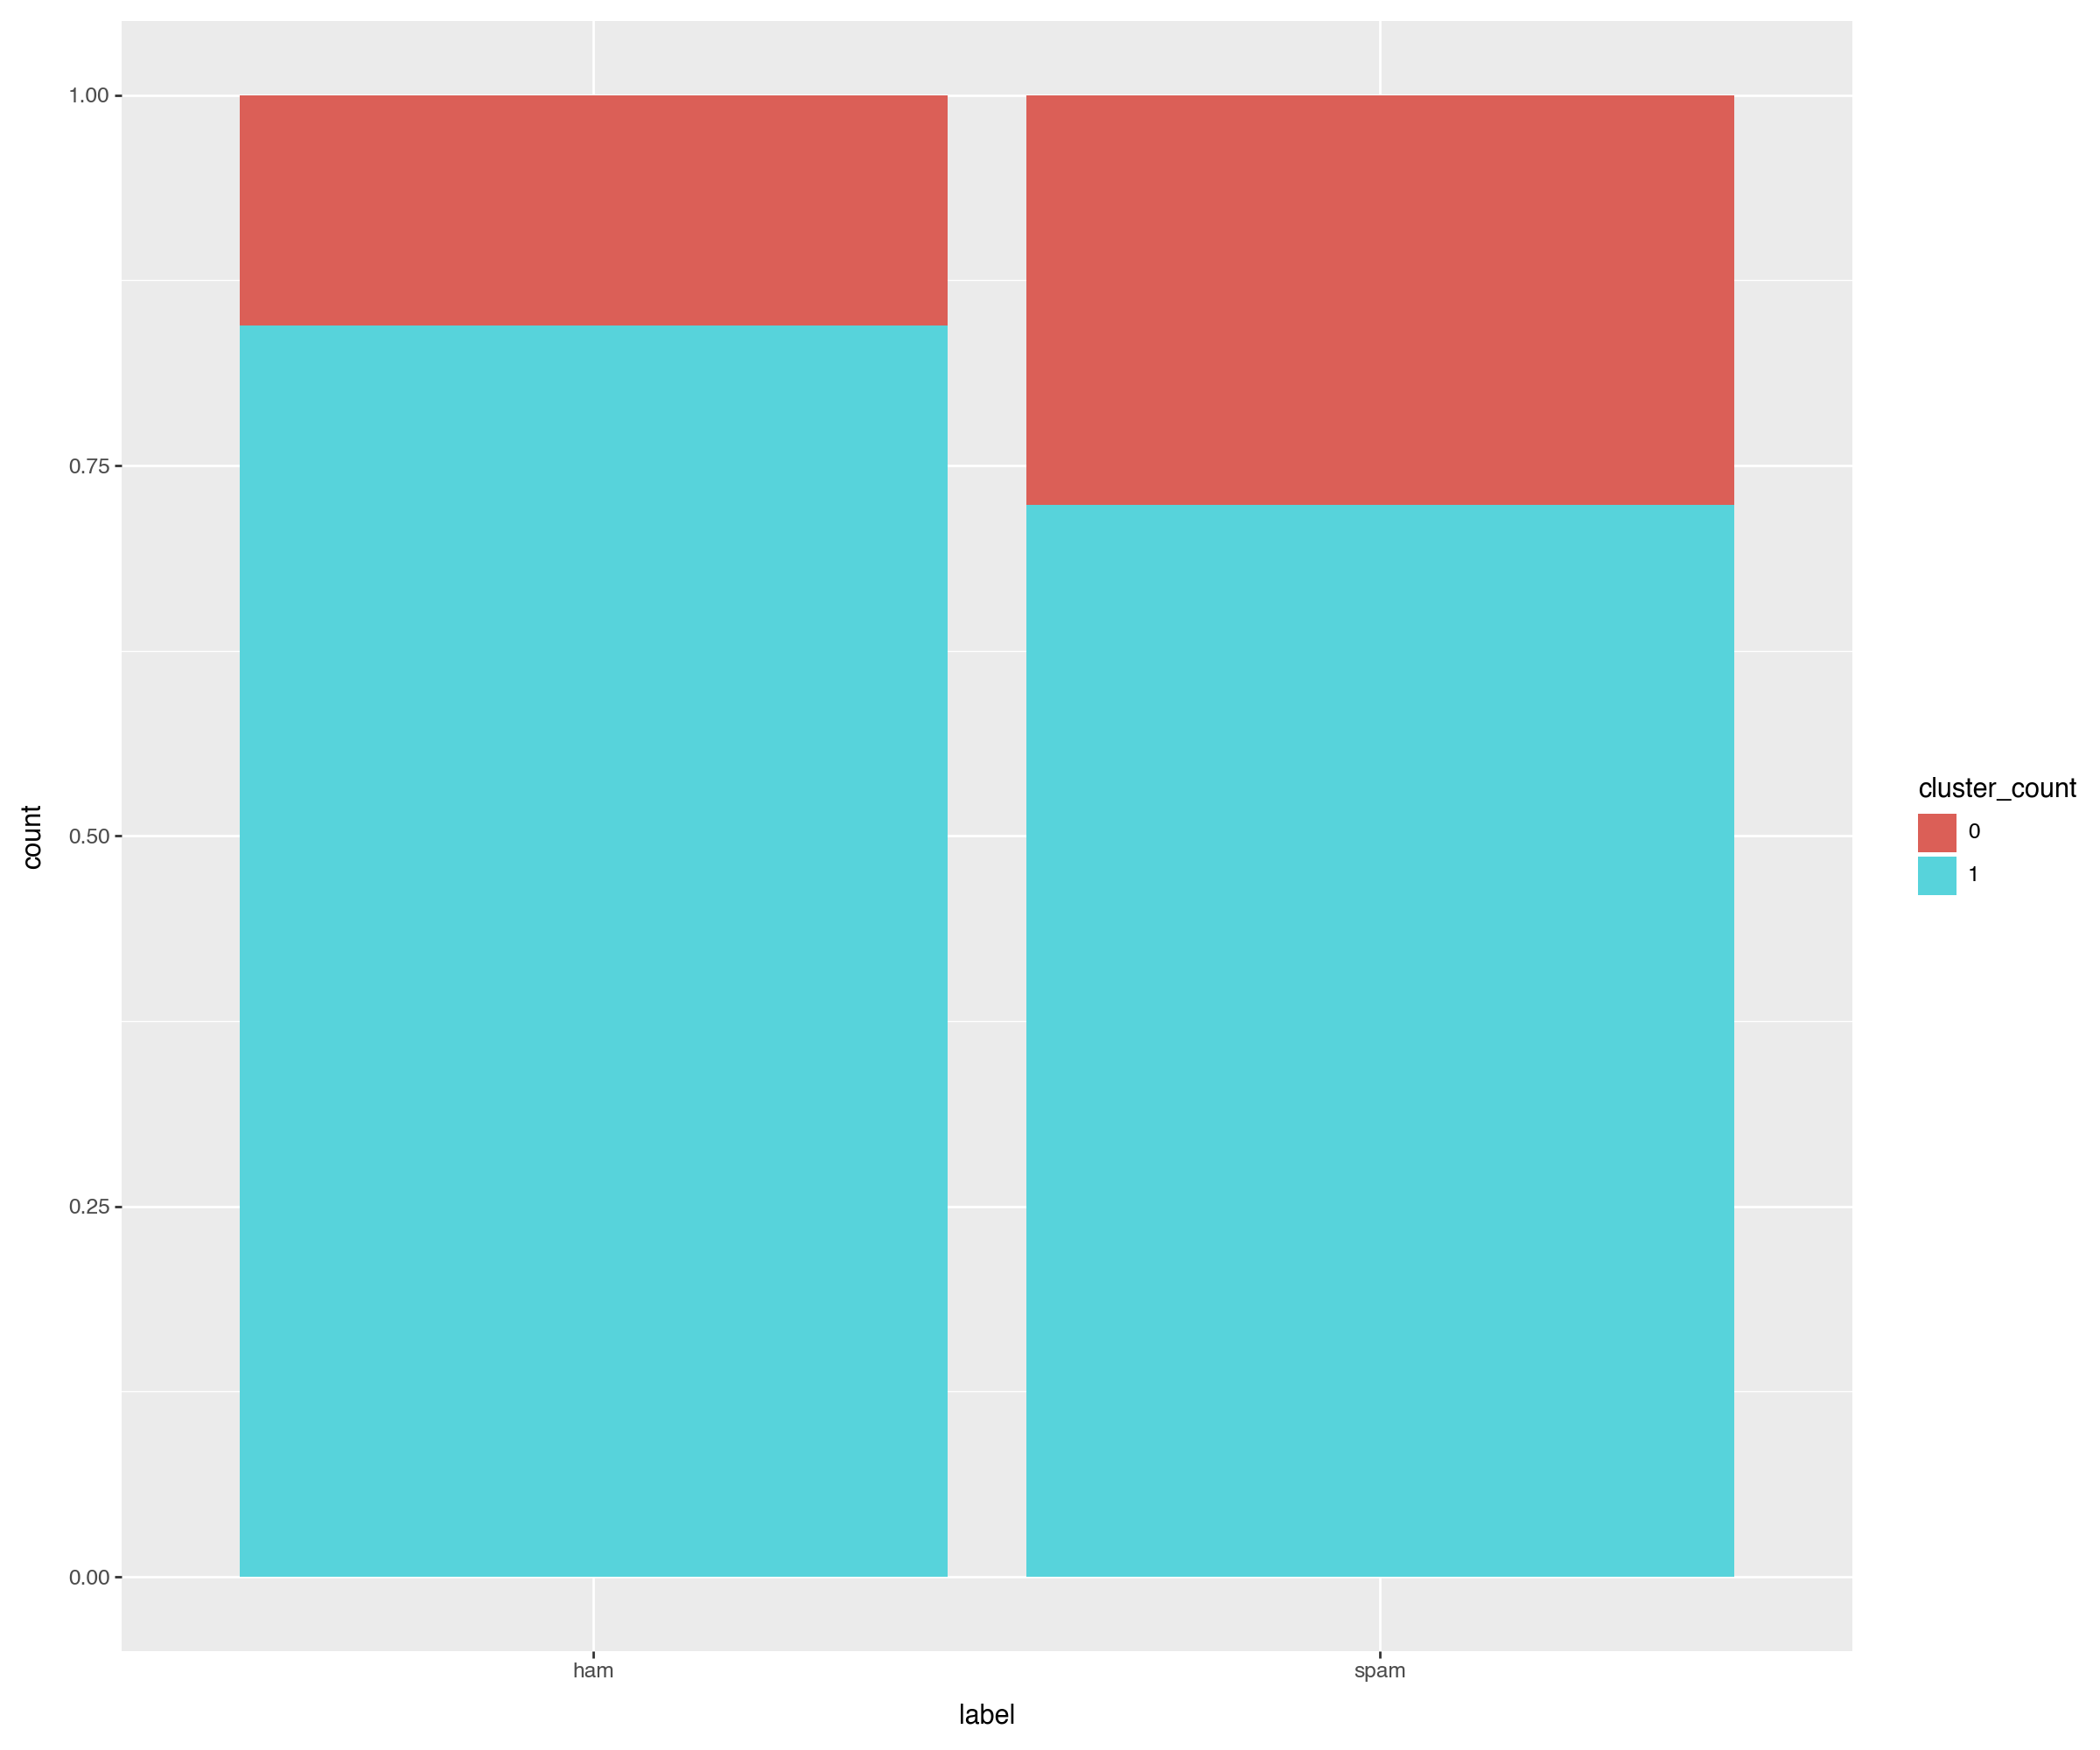

In [17]:
from plotnine import ggplot, aes, geom_bar

(ggplot(data = df_analysis, 
        mapping = aes(x = 'label', 
                     group = 'cluster_count', 
                     fill = 'cluster_count')) 
 + geom_bar(position = 'fill'))

## Klyngeanalyse ud fra TfIdf vectorizer (Tf-idf vægtning af ord)

In [19]:
# Dan TF-IDF vectorizer
vectorizer_tfidf = TfidfVectorizer(
    min_df=0.05,
    max_df=0.9,
    max_features=500
)

# Transform beskeder
transformed_tfidf = vectorizer_tfidf.fit_transform(messages)
tfidf_array = transformed_tfidf.toarray()
tfidf_df = pd.DataFrame(tfidf_array, columns=vectorizer_tfidf.get_feature_names_out())

In [20]:
# K-means clustering
kmeans_tfidf = KMeans(n_clusters=2, random_state=142)
clusters_tfidf = kmeans_tfidf.fit_predict(tfidf_df)

df_analysis['cluster_tfidf'] = clusters_tfidf.astype('str')

In [21]:
cluster_eval_tfidf = pd.crosstab(df_analysis['label'], df_analysis['cluster_tfidf'], normalize='index') * 100

In [22]:
print(cluster_eval_tfidf)

cluster_tfidf          0          1
label                              
ham            27.594340  72.405660
spam           23.026316  76.973684


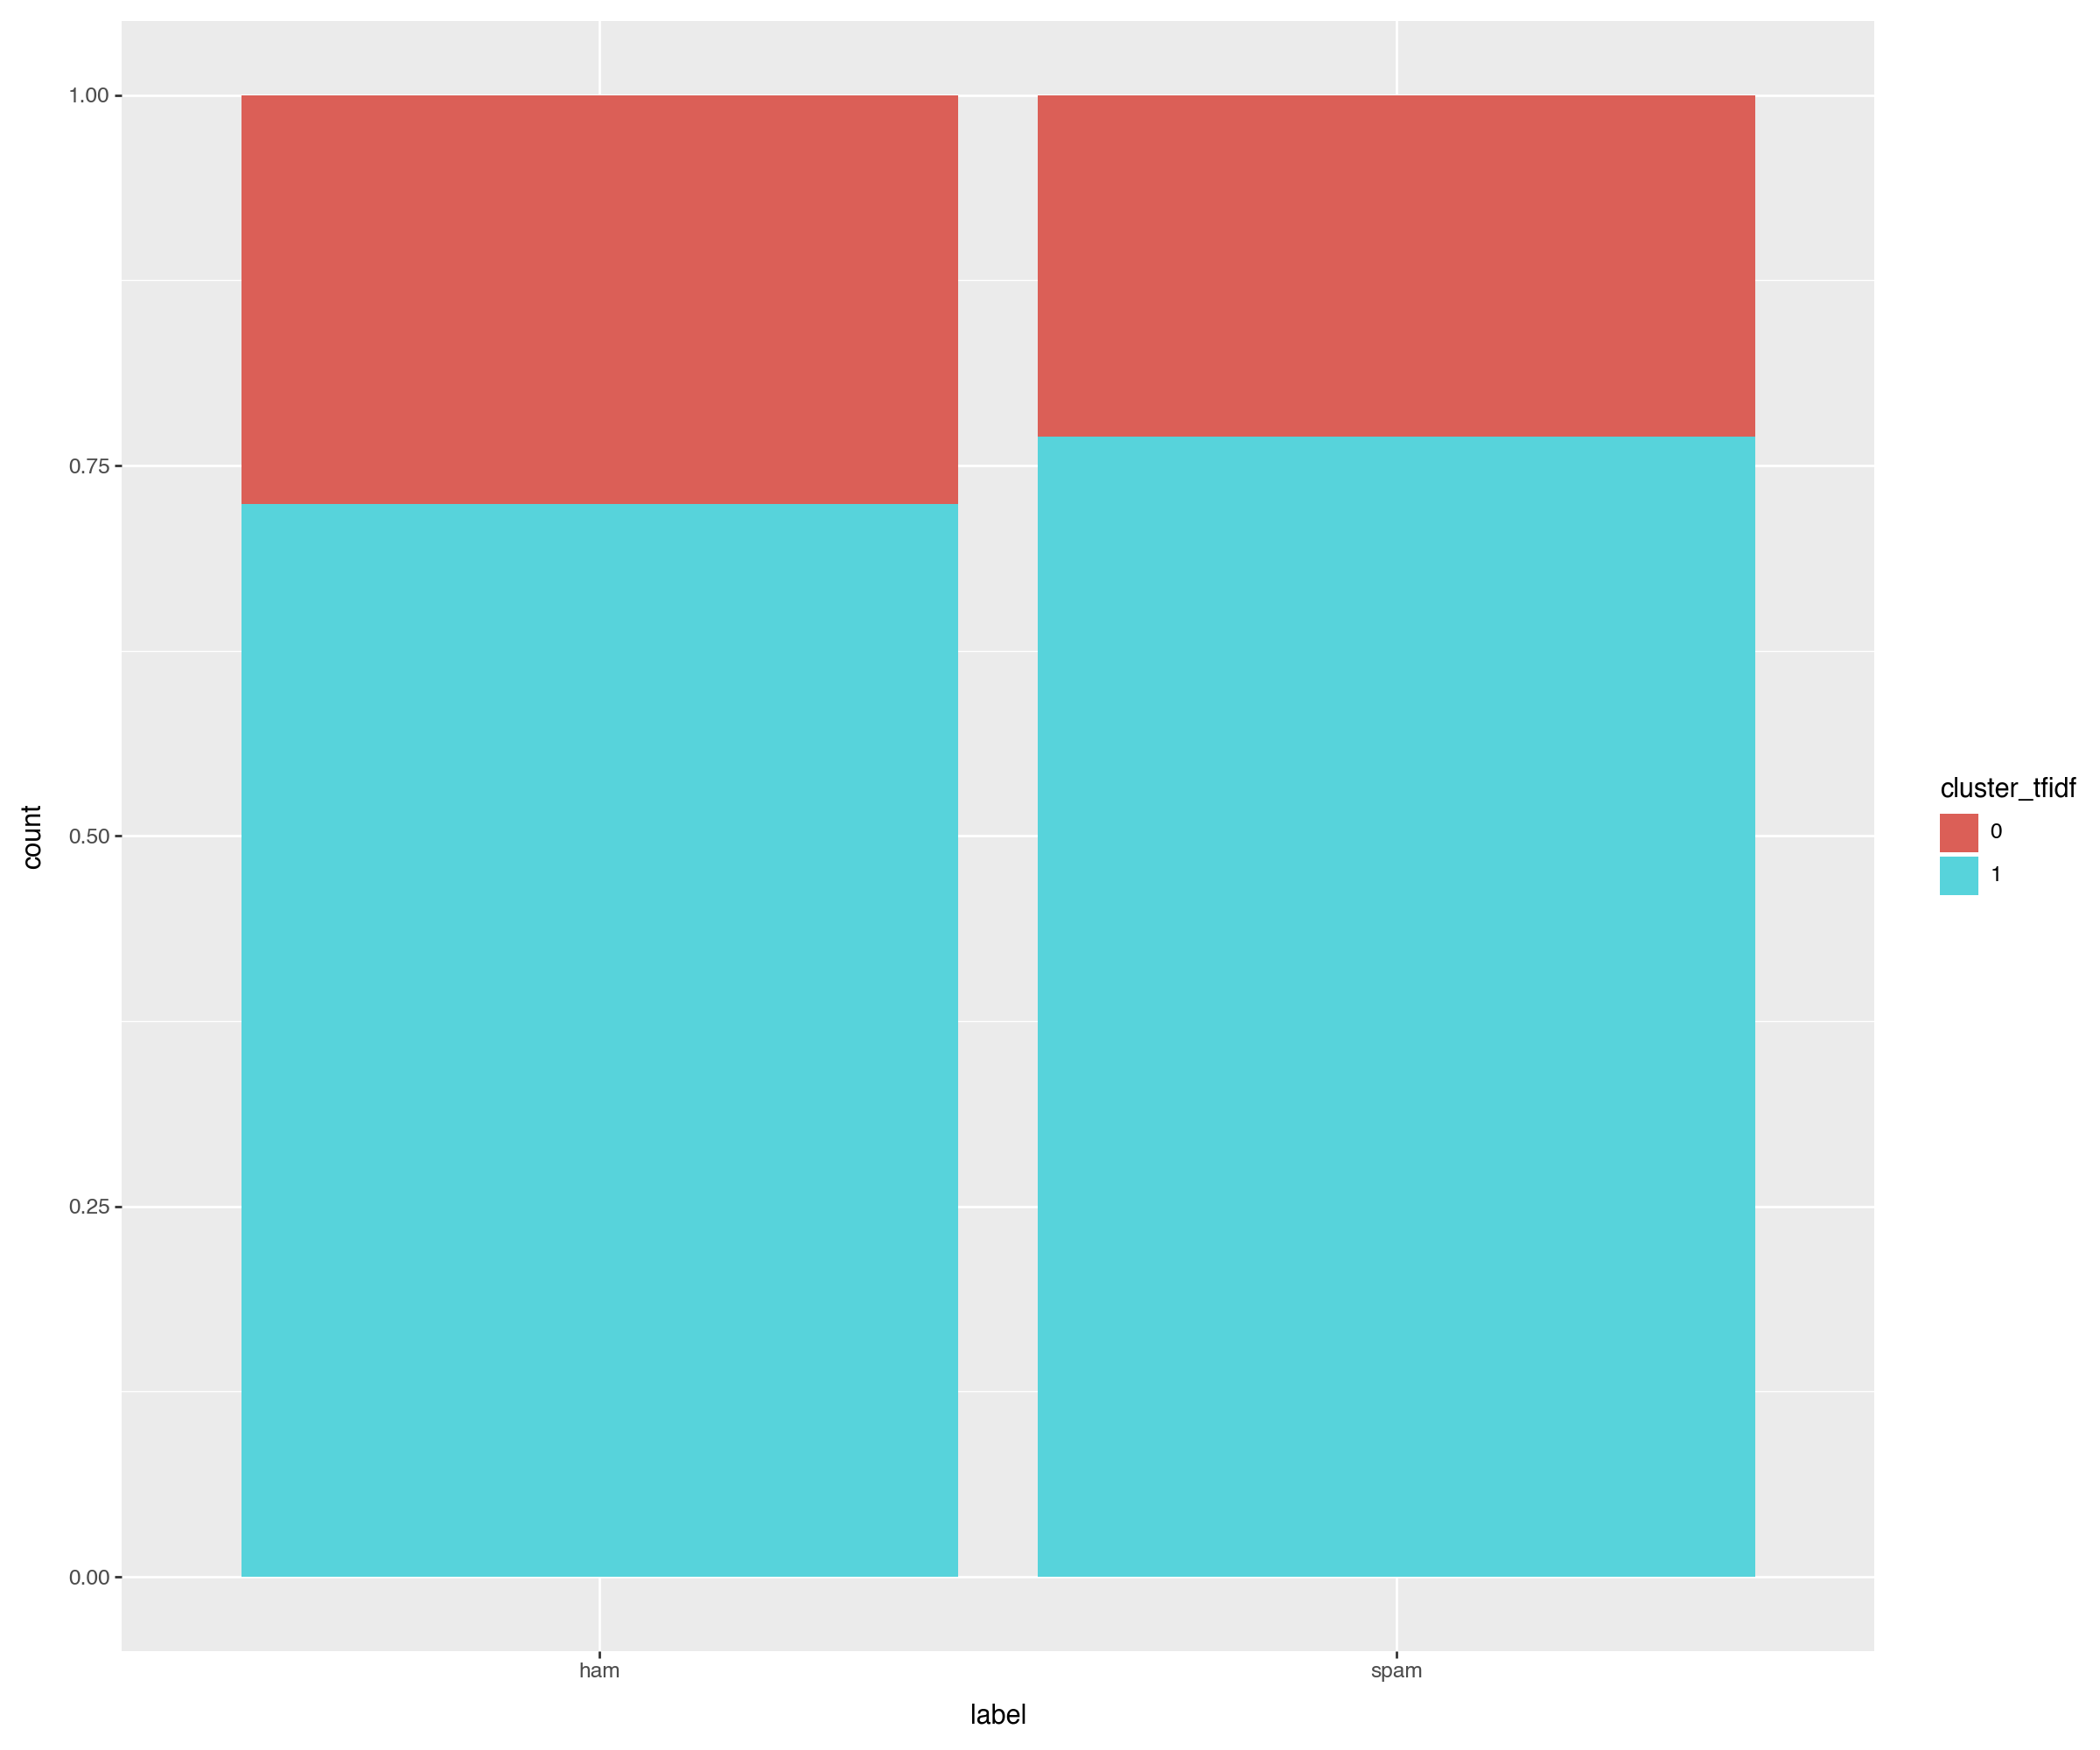

In [23]:
(ggplot(data = df_analysis, 
        mapping = aes(x = 'label', 
                     group = 'cluster_tfidf', 
                     fill = 'cluster_tfidf')) 
 + geom_bar(position = 'fill'))

## Klyngeanalyse ud fra egen tokenizer og TfIdf vectorizer

In [24]:
# Dan custom tokenizer med spaCy
def custom_tokenizer(text):
    """
    Custom tokenizer der bruger spaCy til lemmatisering og POS-filtrering
    """
    # Custom stopord
    custom_stops = ['call', 'text', 'u', 'ur']
    default_stopwords = list(nlp.Defaults.stop_words)
    stop_words = default_stopwords + custom_stops
    
    # Behold kun substantiver, verber og adjektiver
    pos_tags = ['NOUN', 'VERB', 'ADJ', 'PROPN']
    
    doc = nlp(text)
    tokens = []
    
    for word in doc:
        # Mindst 3 tegn
        if len(word.lemma_) < 3:
            continue
        # Tjek POS-tag og stopord
        if word.pos_ in pos_tags and word.lemma_.lower() not in stop_words:
            tokens.append(word.lemma_.lower())
    
    return tokens

In [25]:
# Dan TF-IDF vectorizer med custom tokenizer
vectorizer_custom = TfidfVectorizer(
    min_df=0.05,
    max_df=0.9,
    tokenizer=custom_tokenizer,
    max_features=300
)

# Transform beskeder
transformed_custom = vectorizer_custom.fit_transform(messages)
custom_array = transformed_custom.toarray()
custom_df = pd.DataFrame(custom_array, columns=vectorizer_custom.get_feature_names_out())


/opt/miniconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'


In [26]:
# K-means clustering
kmeans_custom = KMeans(n_clusters=2, random_state=142)
clusters_custom = kmeans_custom.fit_predict(custom_df)

df_analysis['cluster_custom'] = clusters_custom.astype('str')

In [27]:
cluster_eval_custom = pd.crosstab(df_analysis['label'], df_analysis['cluster_custom'], normalize='index') * 100

In [28]:
print(cluster_eval_custom)

cluster_custom          0          1
label                               
ham             95.872642   4.127358
spam            77.631579  22.368421


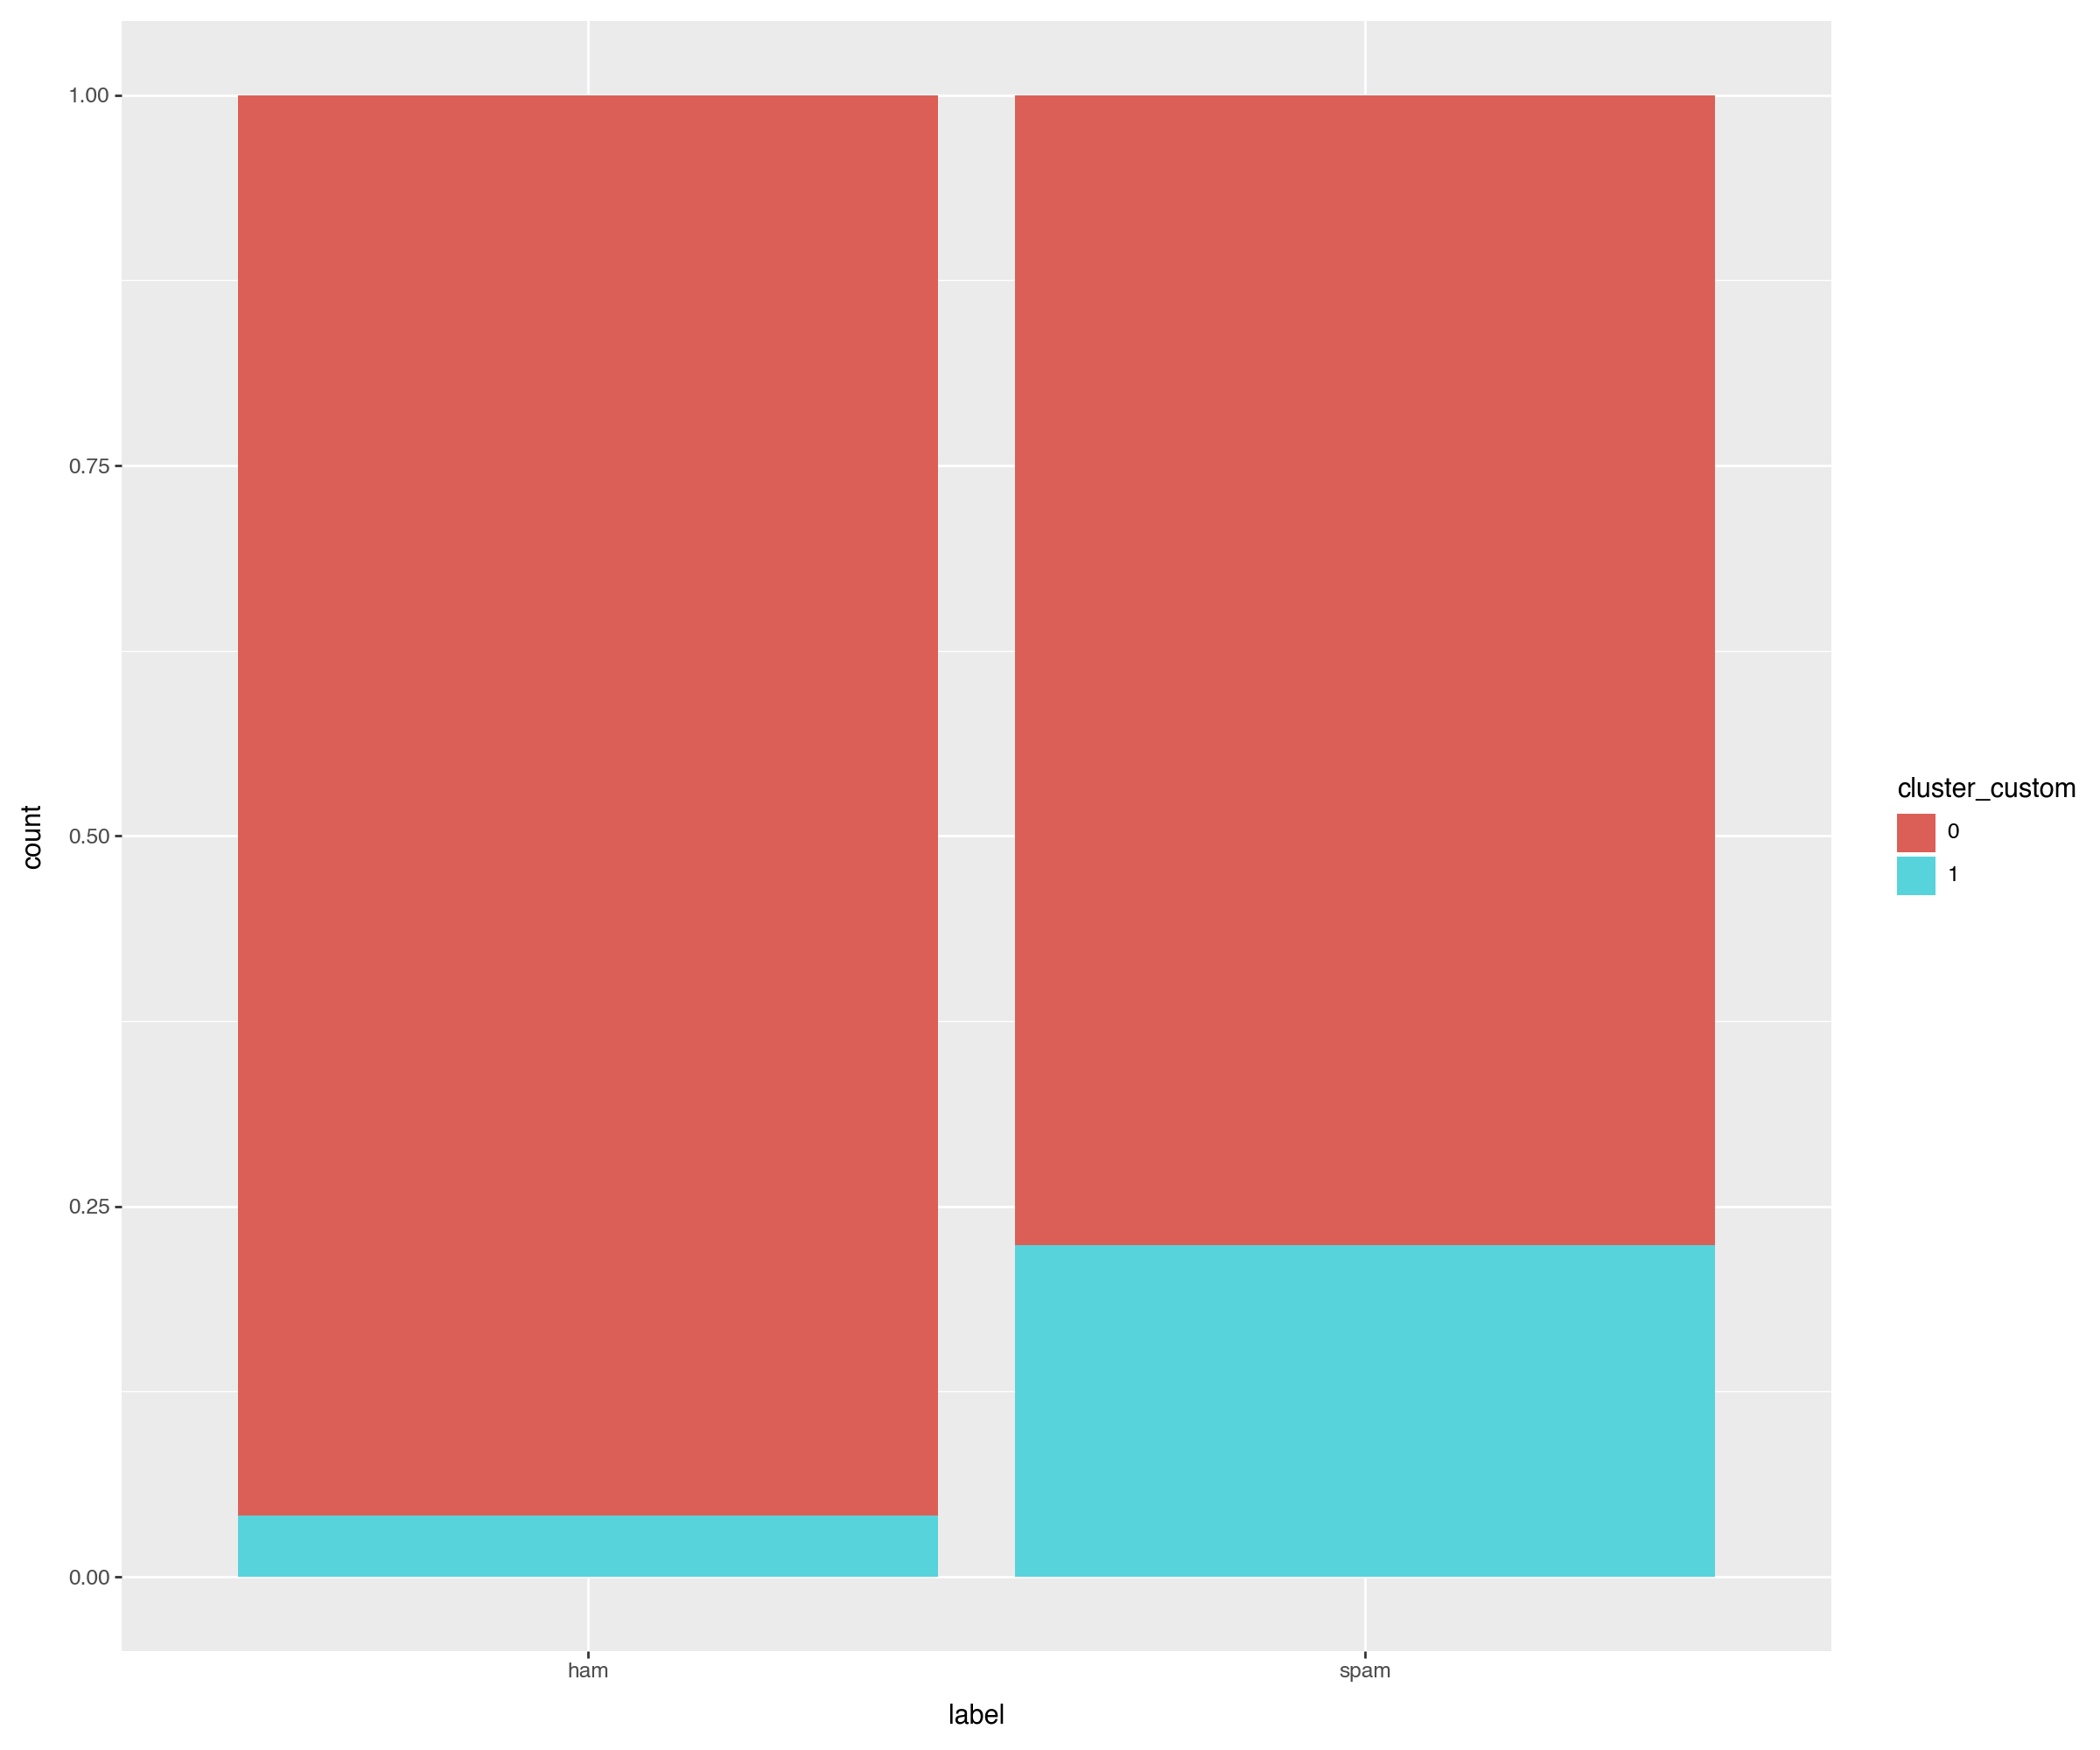

In [29]:
(ggplot(data = df_analysis, 
        mapping = aes(x = 'label', 
                     group = 'cluster_custom', 
                     fill = 'cluster_custom')) 
 + geom_bar(position = 'fill'))

## N-grams

In [53]:
vectorizer_bigram = CountVectorizer(ngram_range=(1, 2), max_features=500, min_df=0.01, stop_words='english')
transformed = vectorizer_bigram.fit_transform(messages)
df_bigram = pd.DataFrame(transformed.toarray(), 
                         columns=vectorizer_bigram.get_feature_names_out())


In [54]:
# K-means clustering
kmeans_ngram = KMeans(n_clusters=2, random_state=142)
clusters_ngram = kmeans_ngram.fit_predict(df_bigram)

df_analysis['cluster_bigram'] = clusters_ngram.astype('str')

In [55]:
cluster_eval_bigram = pd.crosstab(df_analysis['label'], df_analysis['cluster_bigram'], normalize='index') * 100

In [56]:
print(cluster_eval_bigram)

cluster_bigram         0          1
label                              
ham             3.301887  96.698113
spam            1.973684  98.026316


## PCA på tekst

In [69]:
# Udtræk kun beskederne (tekst)
messages = df_analysis['message'].tolist()

# Lav CountVectorizer
vectorizer = CountVectorizer(
    min_df=0.05,
    max_df=0.9,
    max_features=300
)

# Transform til numerisk matrix
X_numeric = vectorizer.fit_transform(messages)
X_array = X_numeric.toarray()

# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=142)
df_analysis['cluster'] = kmeans.fit_predict(X_array).astype('str')

# PCA
pca = PCA(n_components=2, random_state=142)
pca_vecs = pca.fit_transform(X_array)

# Tilføj til DataFrame
df_analysis['pca1'] = pca_tfidf_vecs[:, 0]
df_analysis['pca2'] = pca_tfidf_vecs[:, 1]

In [70]:
print(f"PCA forklaret varians:")
print(f"  Komponent 1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"  Komponent 2: {pca.explained_variance_ratio_[1]*100:.1f}%")
print(f"  Total: {sum(pca.explained_variance_ratio_)*100:.1f}%")

PCA forklaret varians:
  Komponent 1: 16.7%
  Komponent 2: 9.7%
  Total: 26.4%


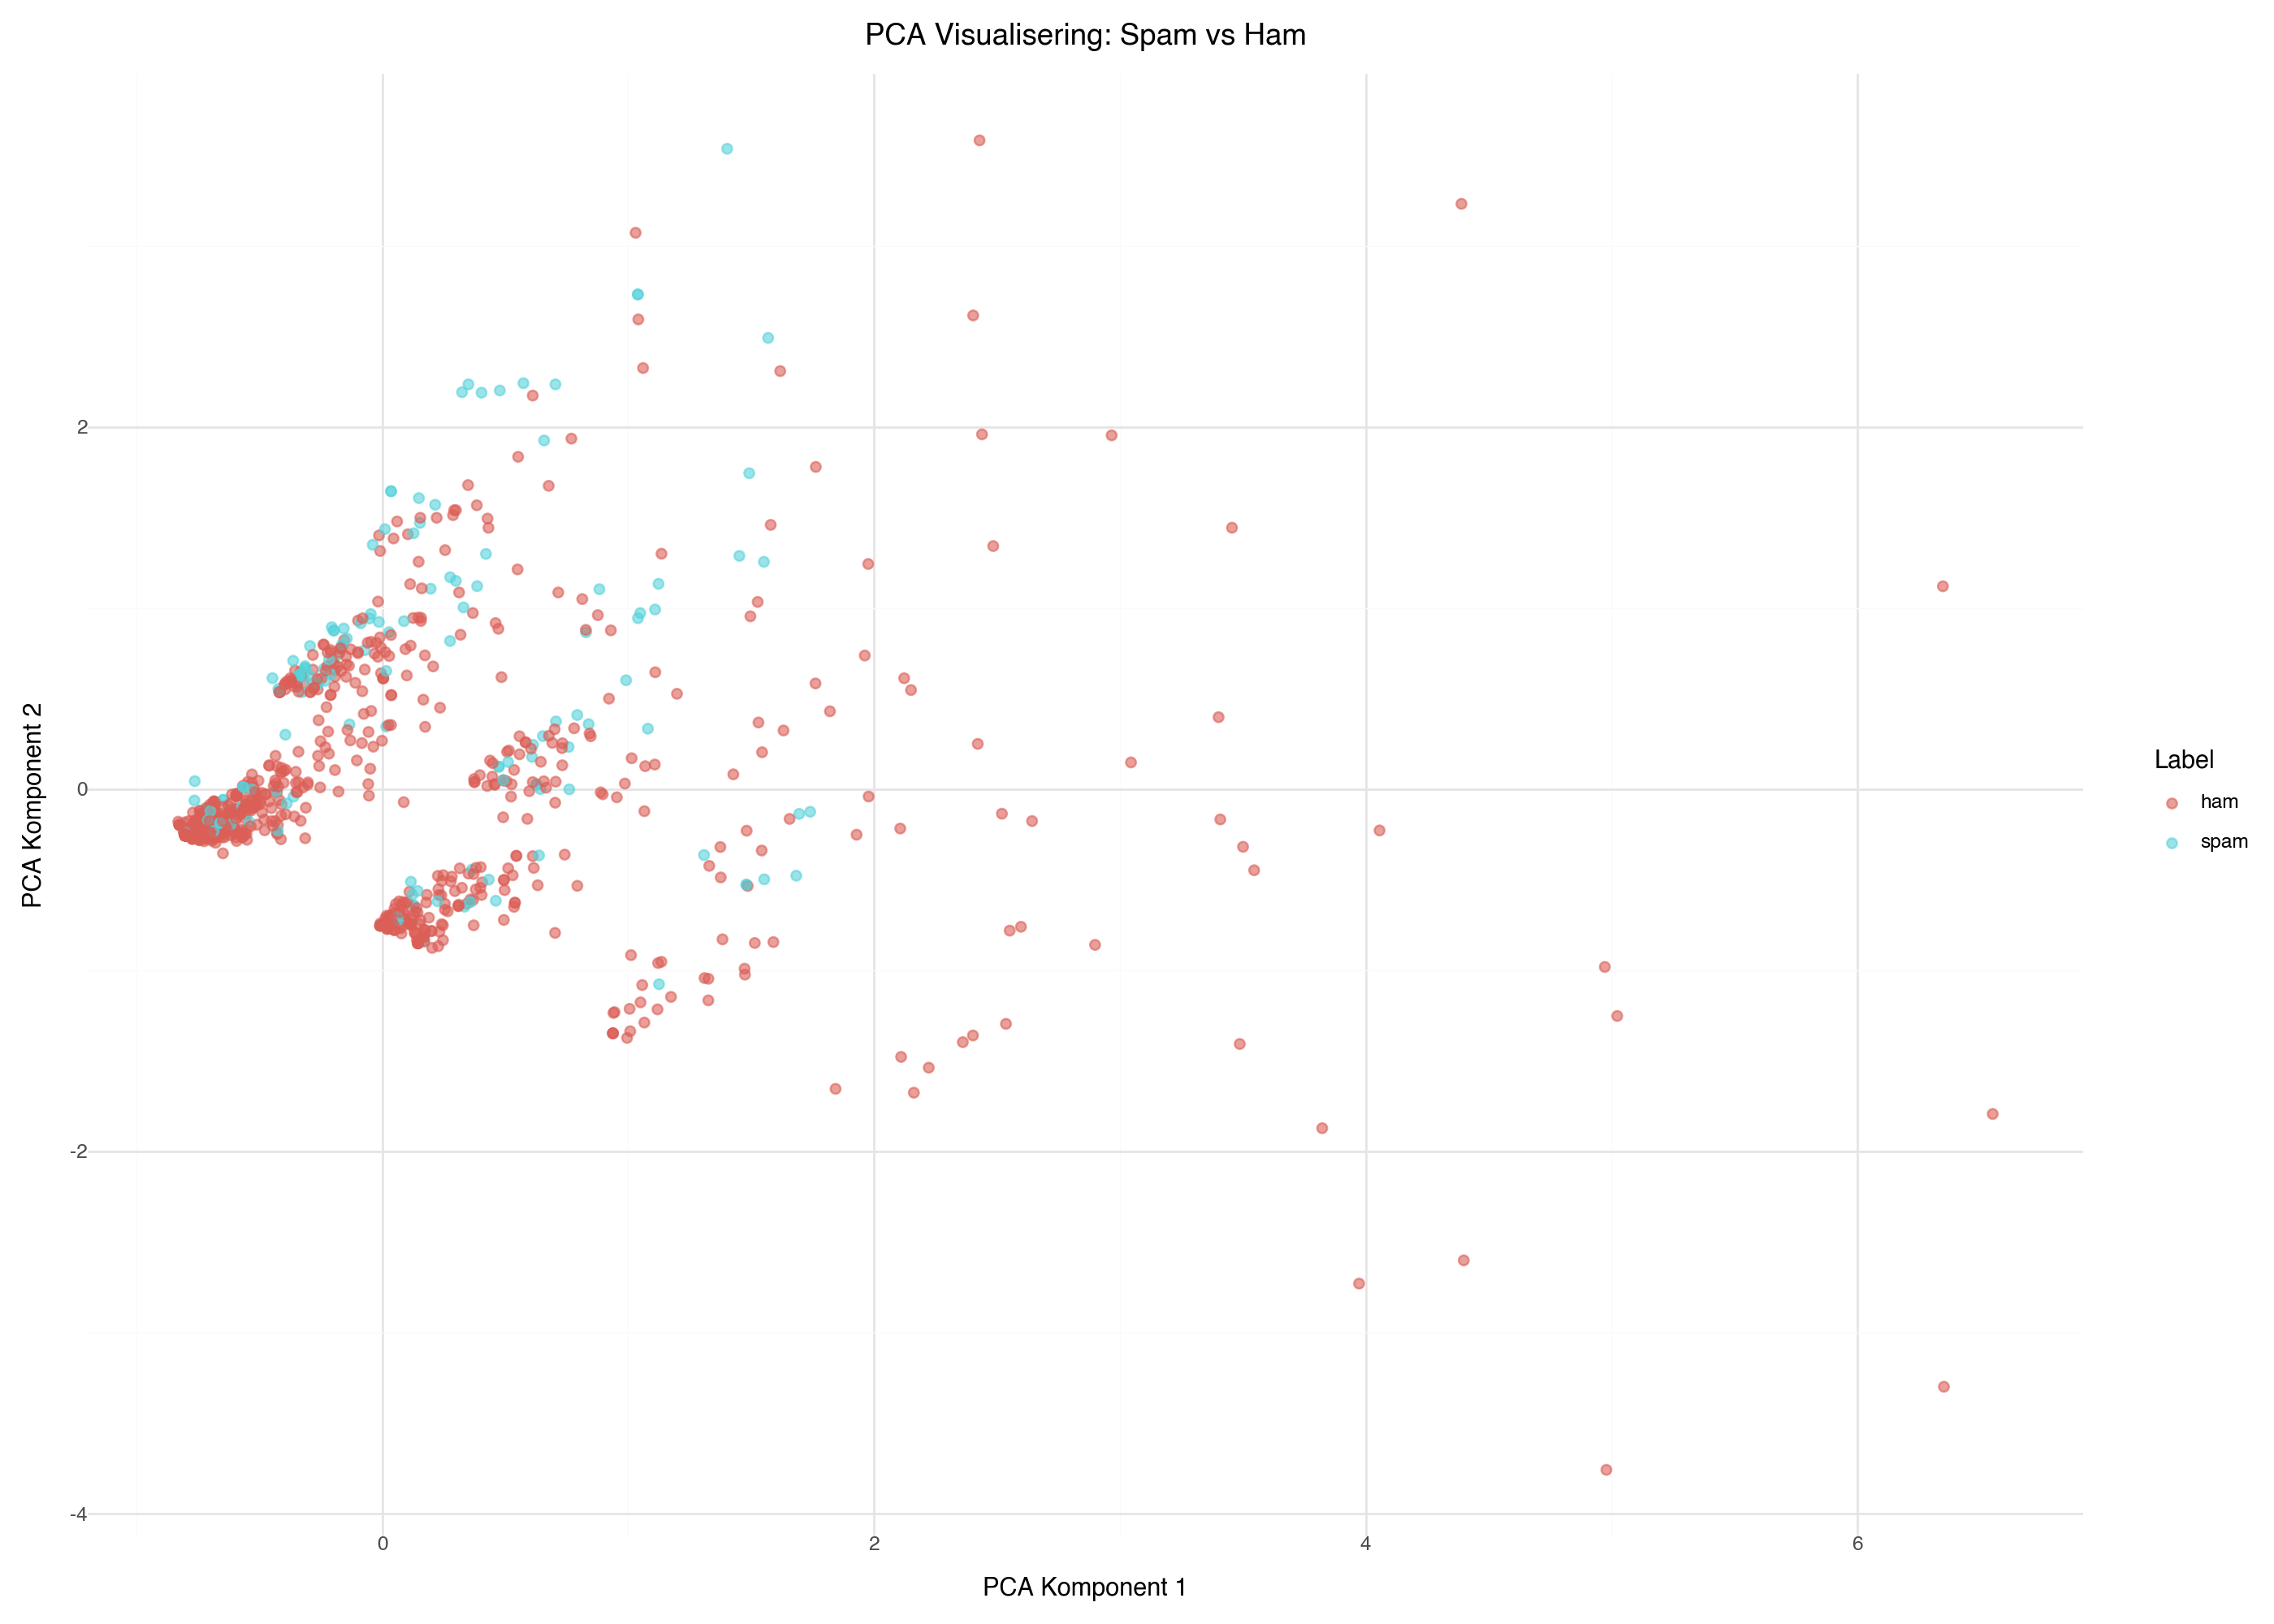

In [71]:
from plotnine import (ggplot, aes, geom_point, labs, theme_minimal, 
                      theme, element_text, facet_wrap, scale_color_manual,
                      scale_shape_manual, geom_density_2d)
plotnine.options.figure_size = (14, 10)

((ggplot(data=df_analysis, 
                mapping=aes(x='pca1', y='pca2', color='label'))
         + geom_point(size=2, alpha=0.6)
         + labs(title='PCA Visualisering: Spam vs Ham',
                x='PCA Komponent 1',
                y='PCA Komponent 2',
                color='Label')
         + theme_minimal()))

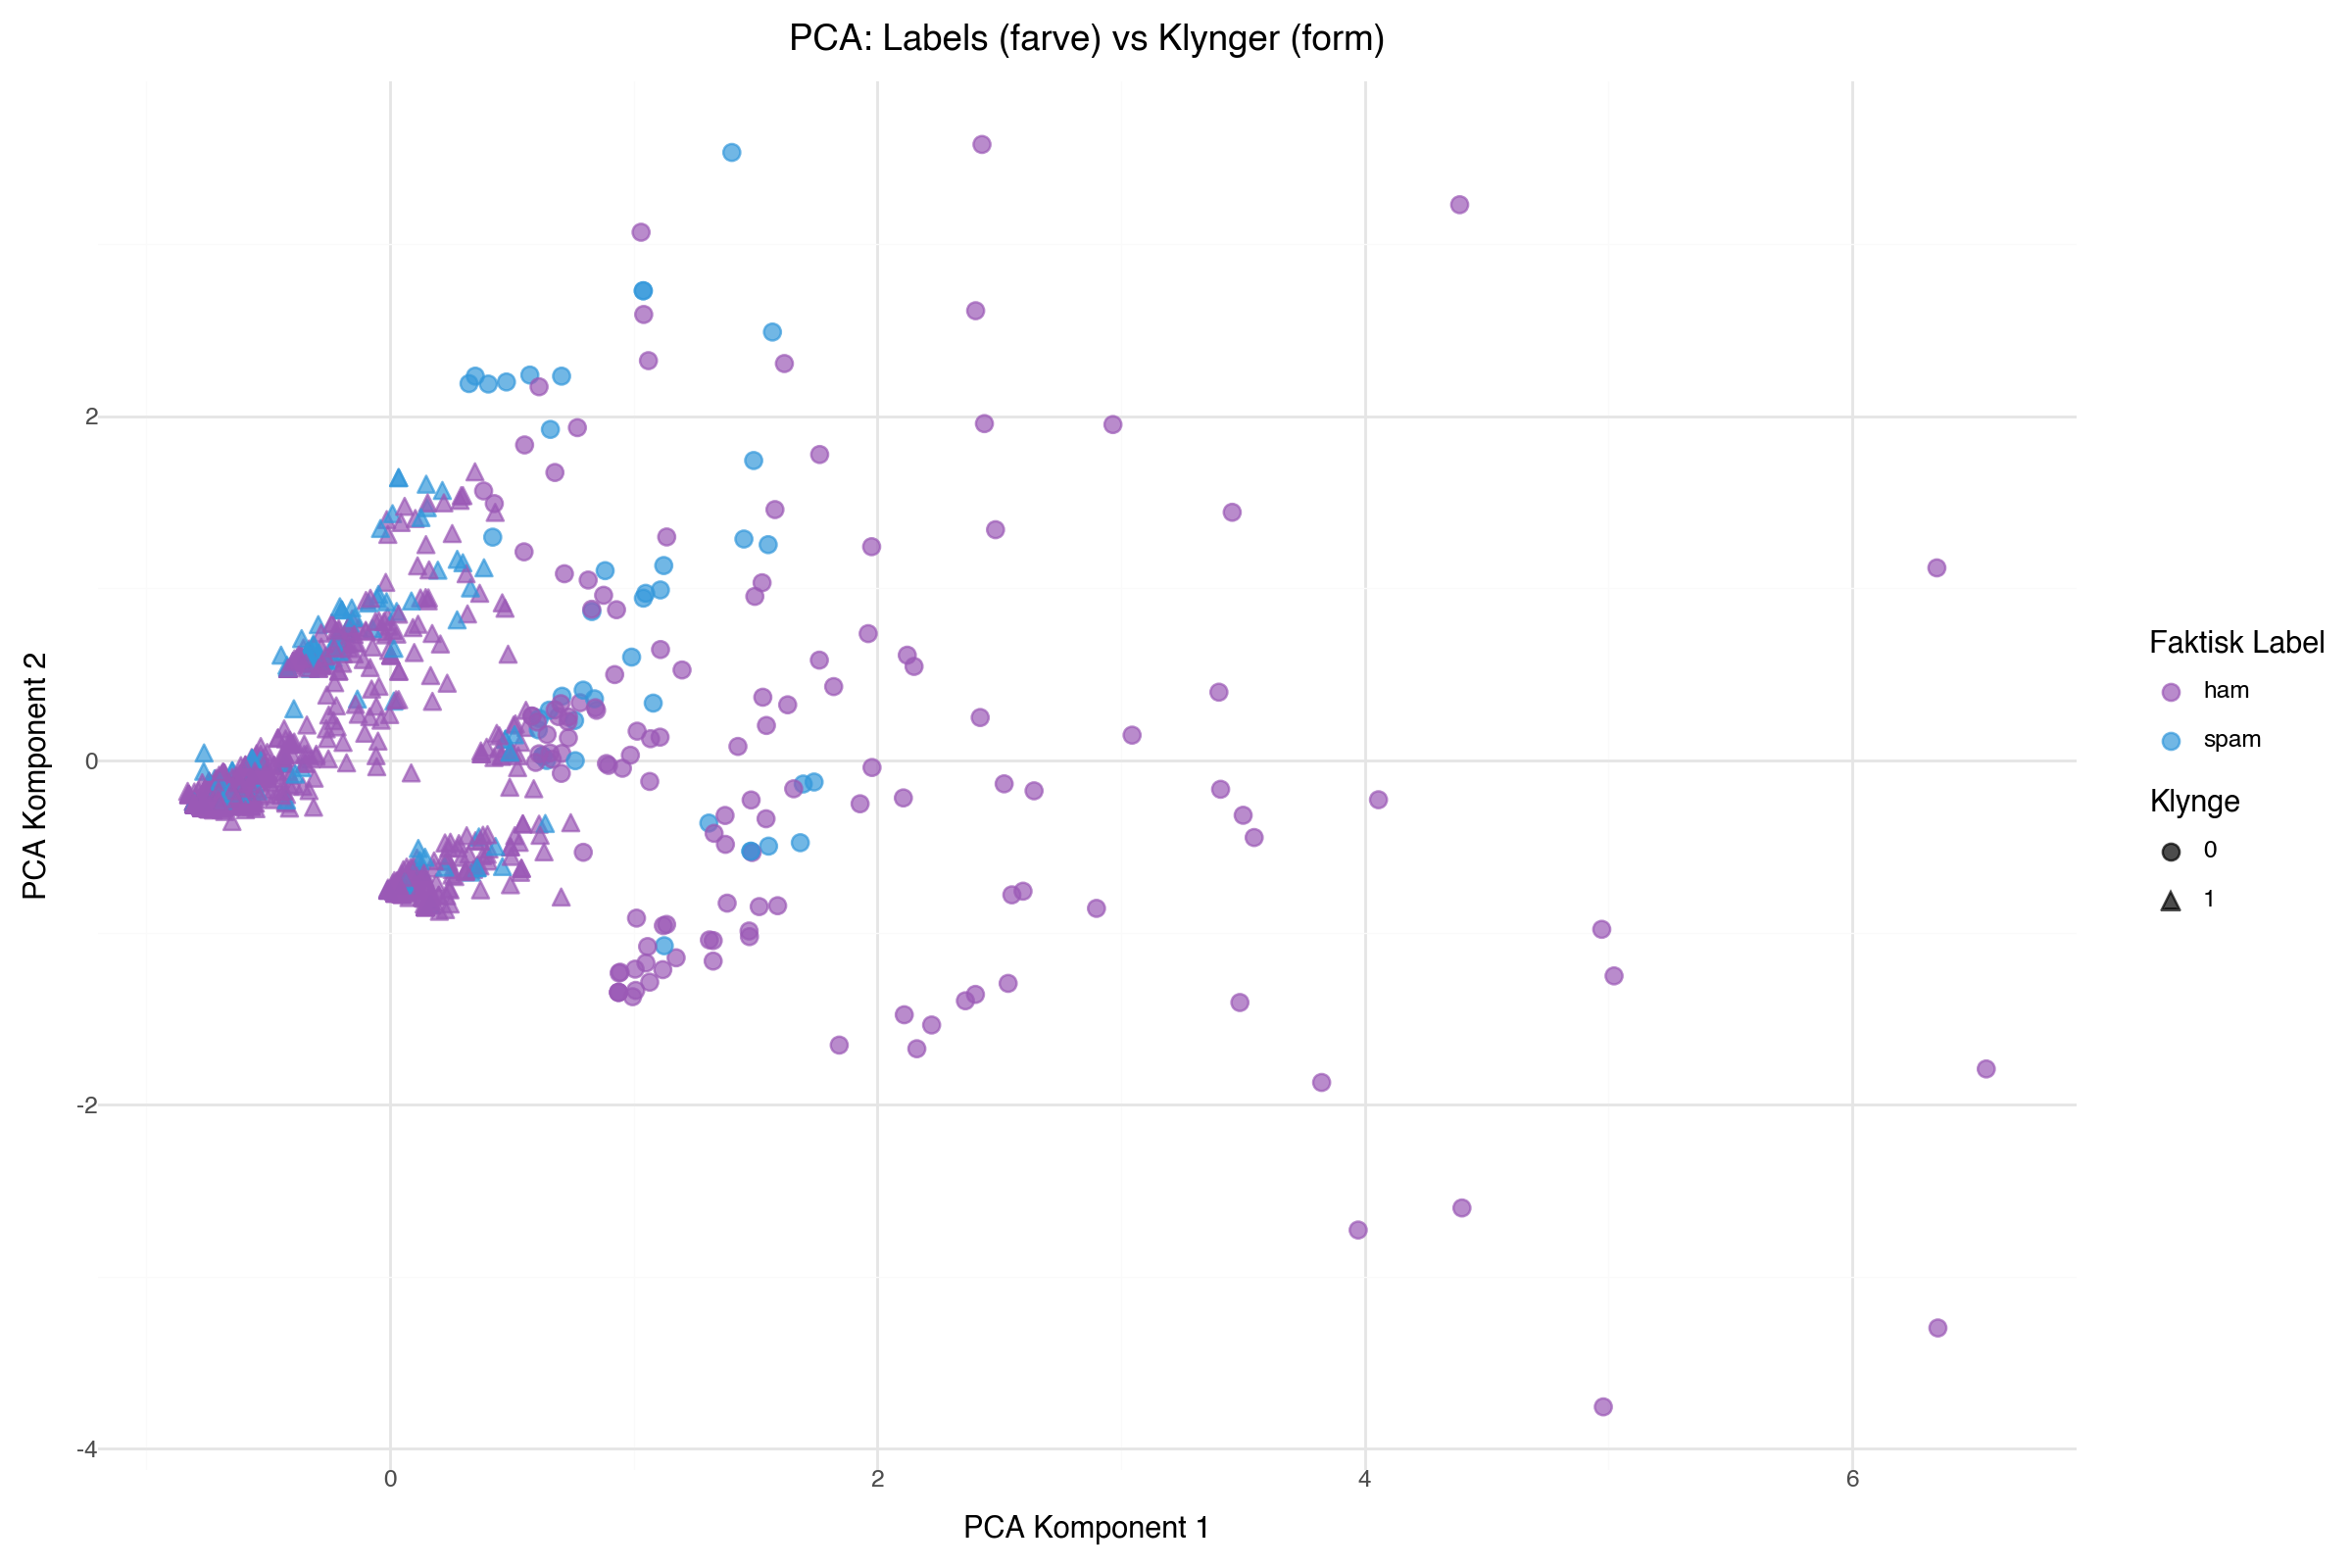

In [75]:
((ggplot(data=df_analysis, 
                mapping=aes(x='pca1', y='pca2', color='label', shape='cluster'))
         + geom_point(size=3, alpha=0.7)
         + scale_color_manual(values={'spam': '#3498db', 'ham': '#9b59b6'})
         + labs(title='PCA: Labels (farve) vs Klynger (form)',
                x='PCA Komponent 1',
                y='PCA Komponent 2',
                color='Faktisk Label',
                shape='Klynge')
         + theme_minimal()
         + theme(figure_size=(12, 8))))